# Multivariate linear regression

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# # %cd gdrive/MyDrive/ML2022/session-1
# %cd gdrive/MyDrive/my_ml_2023/session-6

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random
import utils


# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)

#### Recap

Let us recap the example from the previous notebook: we implemented a very simple network that learned to predict the median house price in an American neighborhood, on the basis of their income. For that purpose, we downloaded the California Housing dataset, defined a simple network, and trained the model. Check the first notebook for more details.

In [3]:
# data loading and preparation:
from sklearn.datasets import fetch_california_housing
california_housing = fetch_california_housing(as_frame=True)


In [4]:
from sklearn.model_selection import train_test_split

X, y = california_housing.frame.drop(['MedHouseVal'], axis=1), california_housing.frame['MedHouseVal']

x_train, x_dev_test, y_train, y_dev_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_dev, x_test, y_dev, y_test = train_test_split(x_dev_test, y_dev_test, test_size=0.5, random_state=42)

In [5]:
feature_names = california_housing.frame.columns[:-1]
print(feature_names)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')


In [6]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train.values)
x_dev = x_scaler.transform(x_dev.values)
x_test = x_scaler.transform(x_test.values)

In [7]:
x_train.shape

(16512, 8)

In [8]:
y_scaler = StandardScaler()

# we add a new dimension to y's (it had just one) to fulfil requirements of StandardScaler (2 dimensions)

y_train = np.expand_dims(y_train.values, axis=1)
y_dev = np.expand_dims(y_dev.values, axis=1)

y_train = y_scaler.fit_transform(y_train)
y_dev = y_scaler.transform(y_dev)

Drawing/printing correlations between variables in data is important because it helps uncover relationships, dependencies, or patterns that may exist between them. Correlations can assist in feature selection by highlighting variables that are most relevant for predicting outcomes, improving model accuracy.

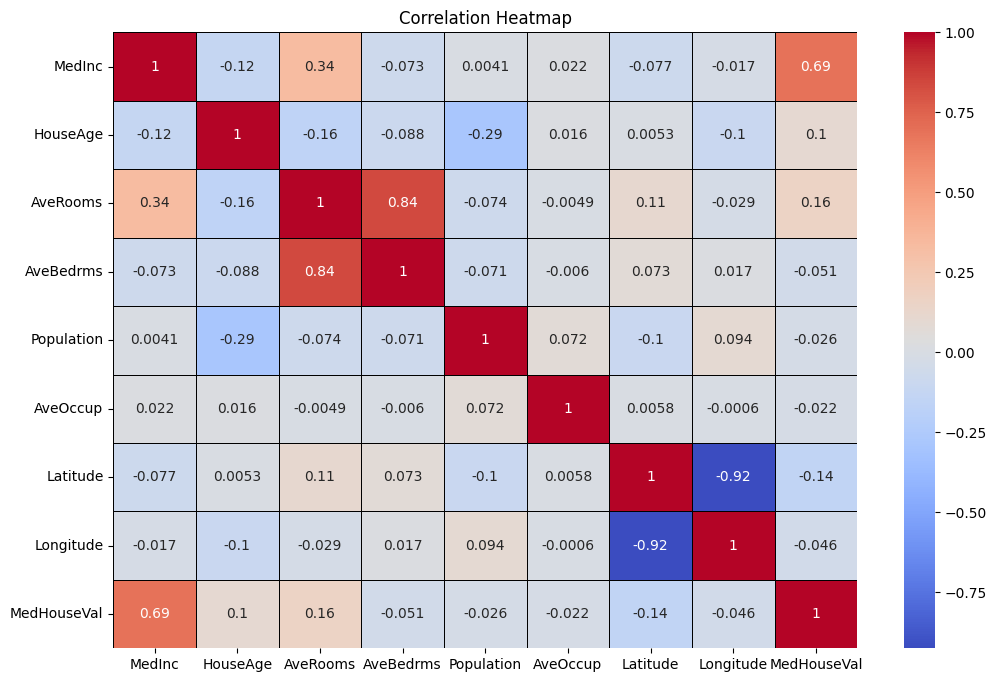

In [9]:
train_df = pd.DataFrame(np.concatenate([x_train, y_train], axis=1), columns=california_housing.frame.columns)
corr_matrix = train_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix,annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap')
plt.show()

In [10]:
corr_matrix['MedHouseVal'].sort_values(ascending=False)

,MedHouseVal
MedHouseVal,1.000000
MedInc,0.690647
AveRooms,0.158485
HouseAge,0.103706
AveOccup,-0.022030
Population,-0.026032
Longitude,-0.046349
AveBedrms,-0.051351
Latitude,-0.142983


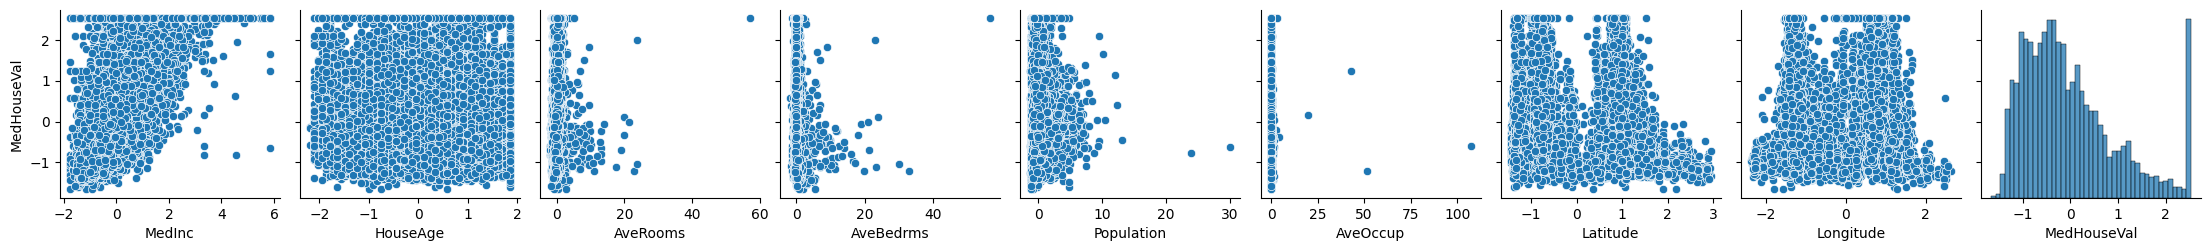

In [11]:
sns.pairplot(train_df,  y_vars=['MedHouseVal'])

We can also plot some distributions:

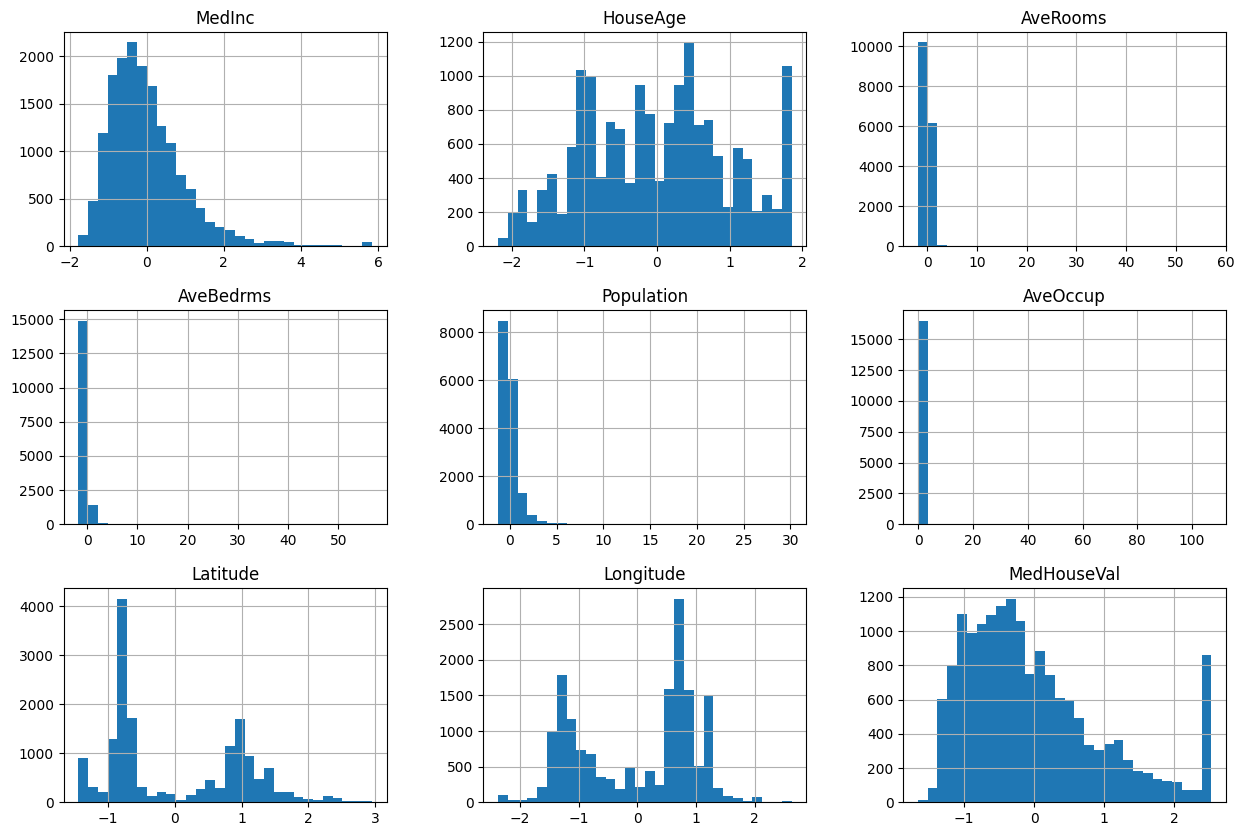

In [12]:
pd.plotting.hist_frame(train_df, figsize=(15,10), bins=30);

Let's train as the same model as in the previous notebook.

In [13]:
x_train = torch.tensor(x_train, dtype=torch.float)
x_dev = torch.tensor(x_dev, dtype=torch.float)
x_test = torch.tensor(x_test, dtype=torch.float)

y_train = torch.tensor(y_train, dtype=torch.float)
y_dev = torch.tensor(y_dev, dtype=torch.float)

In [14]:
u_train_dataset = torch.utils.data.TensorDataset(x_train[:, [0]], y_train)
u_train_iter = torch.utils.data.DataLoader(u_train_dataset, batch_size=len(u_train_dataset), shuffle=True)

u_dev_dataset = torch.utils.data.TensorDataset(x_dev[:, [0]], y_dev)
u_dev_iter = torch.utils.data.DataLoader(u_dev_dataset, batch_size=len(u_dev_dataset), shuffle=False)

u_test_dataset = torch.utils.data.TensorDataset(x_test[:, [0]],  torch.tensor(y_test.values, dtype=torch.float))
u_test_iter = torch.utils.data.DataLoader(u_test_dataset, batch_size=len(u_test_dataset), shuffle=False)

In [15]:
class LinearModel(nn.Module):
  def __init__(self, in_features=1, out_features=1):
    super(LinearModel, self).__init__()
    self.layer = nn.Linear(in_features=in_features, out_features=out_features)

  def forward(self, x):
    return self.layer(x)


In [16]:
uni_model = LinearModel(in_features=1, out_features=1)
uni_model = uni_model.cuda()
history = utils.train(model=uni_model,
                loss=nn.MSELoss(),
                optimizer=torch.optim.SGD(uni_model.parameters(), lr=0.01),
                train_ds=u_train_iter,
                dev_ds=u_dev_iter,
                val_metrics = {"mse": nn.MSELoss()},
                num_epochs=200)


epoch 1 train loss: 3.2272 val_mse: 3.0502
epoch 2 train loss: 3.1201 val_mse: 2.9494
epoch 3 train loss: 3.0172 val_mse: 2.8527
epoch 4 train loss: 2.9185 val_mse: 2.7598
epoch 5 train loss: 2.8236 val_mse: 2.6706
epoch 6 train loss: 2.7325 val_mse: 2.5849
epoch 7 train loss: 2.6450 val_mse: 2.5027
epoch 8 train loss: 2.5610 val_mse: 2.4237
epoch 9 train loss: 2.4803 val_mse: 2.3479
epoch 10 train loss: 2.4028 val_mse: 2.2751
epoch 11 train loss: 2.3283 val_mse: 2.2052
epoch 12 train loss: 2.2568 val_mse: 2.1380
epoch 13 train loss: 2.1882 val_mse: 2.0736
epoch 14 train loss: 2.1222 val_mse: 2.0117
epoch 15 train loss: 2.0589 val_mse: 1.9523
epoch 16 train loss: 1.9981 val_mse: 1.8953
epoch 17 train loss: 1.9397 val_mse: 1.8405
epoch 18 train loss: 1.8836 val_mse: 1.7879
epoch 19 train loss: 1.8297 val_mse: 1.7374
epoch 20 train loss: 1.7780 val_mse: 1.6890
epoch 21 train loss: 1.7283 val_mse: 1.6424
epoch 22 train loss: 1.6805 val_mse: 1.5977
epoch 23 train loss: 1.6347 val_mse: 1.55

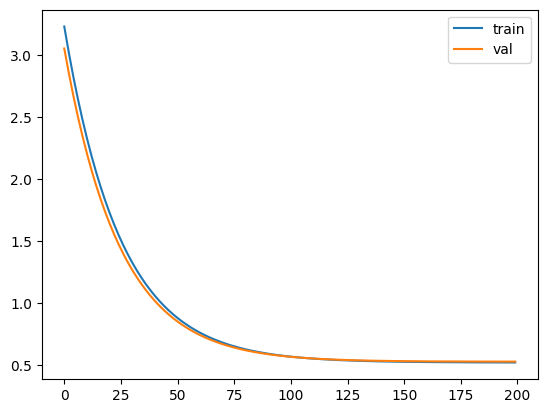

In [17]:
plt.plot(history['train_loss'], label="train")
plt.plot(history['val_mse'], label="val")
plt.legend()

In [18]:
uni_predictions = utils.test(uni_model, u_test_iter)
uni_predictions = y_scaler.inverse_transform(uni_predictions)

## The multivariate case

So far, we've worked with a simple linear model that only had one input (feature) and one output. Consequently, our model only had to learn two parameters:
- a coefficient $w$ (which corresponded to our single input feature)
- a bias $b$ (which corresponded to our single output)

After training, it was easy to obtain predictions from the model, by plugging in the actual numbers into the formula: $x \times w + b$. Funnily, when we move to multivariate regression, nothing changes on the surface. The formula which we will use is still: $x \times w + b$.

Below the surface, however, two things have changes;
- $x$ will now be a vector of input variables ($<x_0, x_1, ..., x_{n - 1}>$).
- $w$ will have become a vector of coefficients ($<w_0, w_1, ..., w_{n-1}>$), namely one coefficient for each input feature.
- $b$ will still be a single scalar (because the number of output units didn't change).

Mathematically, the underlying computation process is therefore somewhat different:

$f(x_{0}, x_{1} , x_{2} ..., x_{n-1}) = w_{0}x_{0} + w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{3} + \ldots + b$

In mathematical notation, however, this is equivalent to:

$\sum_{i=0}^{n-1} \ w_{i} \times x_{i} + b $

where $n$ is the number of variables or features per instance; $x_{i}$ refers to a specific feature at position $i$; $w_{i}$ is the corresponding coefficient for that feature, and $b$ is the (single) bias parameter.

Mathematically, however, we can still express this calculation in a very simple manner using a **dot product**: in our case the dot product is needed to combine the feature vector ($x$) and the corresponding vector of weights or coefficients ($w$). For a single training instance, it is not hard to understand what is going on:

$  f(x_{0}, x_{1} , x_{2} ..., x_{n-1}) = \begin{pmatrix}
  x_{0} & x_{1} & \cdots & x_{n - 1} \\
 \end{pmatrix} \times \begin{pmatrix}
  w_{0}  \\
  w_{1}  \\
  \vdots    \\
  w_{n-1}
 \end{pmatrix} + b=  \sum_{i=0}^{n-1} \ w_{i} \times x_{i} + b $


 $  \begin{pmatrix}
  x_{0} & x_{1} & \cdots & x_{n - 1} \\
 \end{pmatrix} $ is one instance from our training. For instance:

In [19]:
x_train[0]

tensor([-0.3262,  0.3485, -0.1749, -0.2084,  0.7683,  0.0514, -1.3728,  1.2726])

You can easily see how we can:
1. pair each $w_i$ with each $x_i$
2. record the simple product for each feature-coefficient pair ($w_i \times x_i$)
3. sum the products for all these pairs
4. add the bias in the end

The dot product has the interesting property that it can just as easily be applied to all x's in our data set at once. For two x's at once, for instance, the notation would be:

$\hat{y} = \begin{pmatrix}
  x_{0,0} & x_{0,1} & \cdots & x_{0,n-1} \\
  x_{1,0} & x_{1,1} & \cdots & x_{1,n-1} \\
 \end{pmatrix} \times  \begin{pmatrix}
  w_{0}  \\
  w_{1}  \\
  \vdots    \\
  w_{n-1}
 \end{pmatrix} +  b  = \begin{pmatrix}
 \sum_{i=0}^{n - 1} \ x_{0,i} \times w_{i} + b_{0} \\
 \sum_{i=0}^{n - 1}  \ x_{1,i} \times w_{i} + b_{1}
 \end{pmatrix} $

For two items, we will now autimatically get two predictions. Here, we denote $X$ as our entire feature matrix (or any **batch** of items) and furthermore:
- $w$ - vector of weights,
- $\hat{y}$ - vector of predictions
- $y$ - vector of ground-truth values
- $b$ - bias

Consequently:
- $X_{i,j} = i, j$ entry in the $i^{th}$ row and $j^{th}$ column
- $X_{i,:}$ = the $i^{th}$ row (we refer to $i^{th}$ instance with all corresponding features)
- $X_{:,j}$ = the $j^{th}$ column (we refer to $j^{th}$ feature).

The full equation, however, hardly changes:

$f(X) = X \times w + b $

### A multivariate case in PyTorch

Let's scale up our initial example in the California House Dataset from the univariate to the multivariate case. The way we set up the network for the multivariate case looks surprisingly similar to the univariate case. In fact, only a single parameter changes, i.e. the number of incoming features. The training or fitting procedure is also pretty much the same, although we now feed in the entire `x_train`, instead of just a column.

In [20]:
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)

dev_dataset = torch.utils.data.TensorDataset(x_dev, y_dev)
dev_iter = torch.utils.data.DataLoader(dev_dataset, batch_size=len(dev_dataset), shuffle=False)

test_dataset = torch.utils.data.TensorDataset(x_test,  torch.tensor(y_test.values, dtype=torch.float))
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [ ]:
multi_model = LinearModel(in_features=8, out_features=1)

multi_model = multi_model.cuda()

history = utils.train(model=multi_model,
                loss=nn.MSELoss(),
                optimizer=torch.optim.SGD(multi_model.parameters(), lr=0.01),
                train_ds=train_iter,
                dev_ds=dev_iter,
                val_metrics = {"mse": nn.MSELoss()},
                num_epochs=200)

epoch 1 train loss: 1.6016 val_mse: 1.4648
epoch 2 train loss: 1.5436 val_mse: 1.4139
epoch 3 train loss: 1.4889 val_mse: 1.3661
epoch 4 train loss: 1.4376 val_mse: 1.3211
epoch 5 train loss: 1.3892 val_mse: 1.2787
epoch 6 train loss: 1.3437 val_mse: 1.2389
epoch 7 train loss: 1.3008 val_mse: 1.2014
epoch 8 train loss: 1.2603 val_mse: 1.1661
epoch 9 train loss: 1.2222 val_mse: 1.1328
epoch 10 train loss: 1.1863 val_mse: 1.1014
epoch 11 train loss: 1.1524 val_mse: 1.0718
epoch 12 train loss: 1.1204 val_mse: 1.0439
epoch 13 train loss: 1.0902 val_mse: 1.0176
epoch 14 train loss: 1.0617 val_mse: 0.9927
epoch 15 train loss: 1.0347 val_mse: 0.9692
epoch 16 train loss: 1.0092 val_mse: 0.9471
epoch 17 train loss: 0.9851 val_mse: 0.9261
epoch 18 train loss: 0.9623 val_mse: 0.9062
epoch 19 train loss: 0.9407 val_mse: 0.8875
epoch 20 train loss: 0.9203 val_mse: 0.8697
epoch 21 train loss: 0.9010 val_mse: 0.8529
epoch 22 train loss: 0.8826 val_mse: 0.8370
epoch 23 train loss: 0.8652 val_mse: 0.82

As the loss scores, printed out the end of each epoch tell, you we manage to drive down the loss on the house price much further than in the univariate case -- which makes sense because our model can exploit much more features in the process.

In [ ]:
plt.plot(history['train_loss'], label="train")
plt.plot(history['val_mse'], label="val")
plt.legend()

In [ ]:
multi_predictions = utils.test(multi_model, test_iter)
multi_predictions = y_scaler.inverse_transform(multi_predictions)

It is important to remember that we can compare only models tested on **the same** data split. If you use different data splits, your comparision is not valid. It is a typical mistake for the final

In [ ]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

print(f"Univariate MAE: {mae(y_pred=uni_predictions, y_true=y_test)}")
print(f"Multivariate MAE: {mae(y_pred=multi_predictions, y_true=y_test)}")


print(f"Univariate MSE: {mse(y_pred=uni_predictions, y_true=y_test)}")
print(f"Multivariate MSE: {mse(y_pred=multi_predictions, y_true=y_test)}")
